# Transformer Signal Generation 8

In [2]:
import torch
import torch.nn as nn
import os
import math
import h5py
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

# Set Model Save Parameters
model_save_folder = "Model 8" # Model Save Folder Path
model_save_name = "model_8" # Model Name

# Create Save Directories
os.makedirs(model_save_folder, exist_ok=True) # Check if the Model directory exists, if not, create it
model_save_path = os.path.join(model_save_folder, model_save_name)
folder_path = f"{model_save_path}_figures" # Figuers folder save path
os.makedirs(folder_path, exist_ok=True) # Check if the Figures directory exists, if not, create it

# Printout
print(f"Main Save Folder: {model_save_folder}")
print(f"Model Name: {model_save_name}")

Main Save Folder: Model 8
Model Name: model_8


## Model

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :, :]
        return x

class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers,num_decoder_layers, dim_feedforward):
        super(TimeSeriesTransformer, self).__init__()

        self.embedding = nn.Linear(1, d_model) 
        self.pos_encoder = PositionalEncoding(d_model)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        # Decoder for force
        self.decoder_layer_force = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_decoder_force = nn.TransformerDecoder(self.decoder_layer_force, num_layers=num_decoder_layers)
        self.output_force = nn.Linear(d_model, 1) # Assuming output dimension is same as d_model

        # the decoder for disp
        self.decoder_layer_disp = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_decoder_disp = nn.TransformerDecoder(self.decoder_layer_disp, num_layers=num_decoder_layers)
        self.output_disp = nn.Linear(d_model, 1)

    def forward(self, seq1, padding_mask=None):
        # pre-processing: input is (batch, L,D)
        seq1 = torch.permute(seq1,(1,0,2)) # reshape it to (L, B, D)
        padding_mask = padding_mask.permute(0,1) # mask input only has one D

        src = self.embedding(seq1)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(src,src_key_padding_mask=padding_mask)
 
        output_force = self.transformer_decoder_force(memory, memory, tgt_key_padding_mask=padding_mask)
        output_force = self.output_force(output_force)
        output_force = output_force.permute(1,0,2) # change the shape back to (B, L, D)
       
        output_disp = self.transformer_decoder_disp(memory, memory, tgt_key_padding_mask=padding_mask)
        output_disp = self.output_disp(output_disp)
        output_disp = output_disp.permute(1,0,2)

        return output_force, output_disp

## Functions

In [4]:
#Functions

# Custom dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, input_data, target_force, target_disp, metadata, mask_list):
        self.input_data = torch.tensor(input_data, dtype=torch.float32)
        self.target_force = torch.tensor(target_force, dtype=torch.float32)
        self.target_disp = torch.tensor(target_disp, dtype=torch.float32)
        self.metadata = metadata # doesn't need to be a tensor
        self.mask_list = torch.tensor(mask_list, dtype=torch.float32)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return (self.input_data[idx],
                  self.target_force[idx],
                  self.target_disp[idx],
                  self.mask_list[idx],
                  self.metadata[idx])

# Normalize sequence to have mean = 0 and std = 1
def normalize_columns(matrix):
    # Compute the mean and standard deviation for each column
    col_means = matrix.mean(axis=0)
    col_stds = matrix.std(axis=0)
    if np.any(col_stds==0):
        print("ERROR: Standard Deviation is 0. Check that all series vary in value")
    normalized_series = (matrix - col_means) / col_stds
    return normalized_series, [col_means, col_stds]


def normalize_all_columns(ts_data):
    normalized_ts_data, original_mean_std = [], [] # Initialize
    for sequence in ts_data:
        norm_seq, mean_std = normalize_columns(sequence[:, 0:5])  # normalize the first 5 columns
        normalized_ts_data.append(norm_seq)
        original_mean_std.append(mean_std)
    return normalized_ts_data, original_mean_std
    

def denormalize(normalized_sequence, original_mean, original_std):
    denormalized_sequence = (normalized_sequence * original_std) + original_mean
    return denormalized_sequence

# Add padding to max length
def pad_data(ts_data):
    padded_series_list, ppl_list, mask_list = [], [], []  # Initialize lists to hold the padded time series, original lengths, and padding masks
    max_length = max(len(series) for series in ts_data)  # Find the length of the longest time series

    for series in ts_data:
        padding_length = max_length - len(series)  # Calculate the number of rows to pad
        padding = np.zeros((padding_length, series.shape[1]))  # Create the padding rows
        padded_series = np.vstack((series, padding))  # Append the padding to the end of the series
        padded_series_list.append(padded_series)  # Add the padded series to the new list
        ppl_list.append(len(series))  # Record the original series length to remove padding later

        # Create the padding mask for the current series
        mask = [False] * len(series) + [True] * padding_length  # False where original data is, True where padding is added
        mask_list.append(mask)  # Add the padding mask to the mask list

    return padded_series_list, ppl_list, mask_list


# Takes in unpadded sequences and returns mask
def create_mask(sequences, max_length):
        padding_mask = np.zeros((len(sequences), max_length), dtype=bool) 
        for i, sequence in enumerate(sequences):
             padding_mask[i, len(sequence):] = True
        return padding_mask 

# Define Loss Function
def loss_function(pred_force, target_batch_force, pred_disp, target_batch_disp):
    mse_loss_force = nn.MSELoss()(pred_force, target_batch_force)
    mse_loss_disp = nn.MSELoss()(pred_disp, target_batch_disp)
    l1_loss_force = nn.L1Loss()(pred_force, target_batch_force)
    l1_loss_disp = nn.L1Loss()(pred_disp, target_batch_disp)
    return (mse_loss_force + mse_loss_disp) + 0.15 * (l1_loss_force + l1_loss_disp)

# Combined RMSE function
def combined_rmse(target_force, pred_force, target_disp, pred_disp):
    # Concatenate all targets and predictions
    Y_combined = np.concatenate((target_force, target_disp))
    Ypre_combined = np.concatenate((pred_force, pred_disp))
    # Calculate and return RMSE
    return np.sqrt(np.mean((Y_combined - Ypre_combined) ** 2))

# Combined R Squared function
def combined_r2(target_force, pred_force, target_disp, pred_disp):
    # Concatenate all targets and predictions
    Y_combined = np.concatenate((target_force, target_disp))
    Ypre_combined = np.concatenate((pred_force, pred_disp))
    # Calculate SSR and SST for combined data
    ssr = np.sum((Y_combined - Ypre_combined) ** 2)
    sst = np.sum((Y_combined - np.mean(Y_combined)) ** 2)
    # Calculate and return R^2
    return 1 - (ssr / sst)

## Data Loader

In [5]:
# Open the HDF5 file in read mode
data_path = r'C:\Users\eyo232\OneDrive - University of Kentucky\3 - GM Spot Weld\1 - Data\HDF5 Databases\DOE 1 v3 [Modified].h5'
file = h5py.File(data_path, 'r')

# Print out the attributes (Metadata)
first_key = list(file.keys())[0] # get the key (name) of the first weld
print("Included Attributes:")
for key, value in file[first_key].attrs.items():
    print(f"\t{key}: {value}")


ts_data, weld_names = [], [] # 3d array (array of 2d matrices)
for weld_name in file:
    ts_data.append(file[weld_name][:]) # add whole time series matrix to the ts_data array
    weld_names.append(weld_name)

# save headers as a variable
headers = file[first_key].attrs['headers']

print(f"\nSuccessfully imported {len(ts_data)} data points")
print(f"ts_data weld 1 size: {ts_data[0].shape}")

Included Attributes:
	Bi-CurrentType: Single
	Bi-PartID: 1059201
	Bi-UniqueSampleNo: StSt075_220531-I030-WL-7-1-1
	Coating #1: AS-4IDL
	Coating #2: AS-4IDL
	Current_S1 (kA): 7.0
	CustomStackup: 1
	Force_S1: 2.6
	Grade #1: PHS-1500
	Grade #2: PHS-1500
	Stackup#: StSt075
	Supplier #1: CC
	Supplier #2: CC
	Thickness #1 (mm): 1.0
	Thickness #2 (mm): 1.0
	extended_notes: 2.6kN,585lbs,StSt075,170ms@7kA,HT=40ms,Size_2_Caps
	headers: ['resistance_data' 'force' 'Bi-Disp-GunStiff' 'current_data' 'Bi-Msec'
 'Schedule']
	vspotid: StSt075-I030-WL-7

Successfully imported 708 data points
ts_data weld 1 size: (170, 6)


## Data Preparation

In [6]:
disp_index, force_index, input_index = 0,1,2 # assign english names to the indexes for readability
data_length = int(len(ts_data)) # define new data length

# Normalize and Pad Data
normalized_ts_data, original_mean_std = normalize_all_columns(ts_data)
padded_series_list, ppl_list, mask_list = pad_data(normalized_ts_data)

# Prepare attributes
metadata = []
for i in range(data_length): # for each sequence loaded...
    input_mean, input_std = original_mean_std[i][0][input_index], original_mean_std[i][1][input_index] # get mean and std from input sequence
    force_mean, force_std = original_mean_std[i][0][force_index], original_mean_std[i][1][force_index] # get mean and std from force sequence
    disp_mean, disp_std = original_mean_std[i][0][disp_index], original_mean_std[i][1][disp_index] # get mean and std from displacement sequence
    
    metadata.append([weld_names[i], ppl_list[i], input_mean, input_std, force_mean, force_std, disp_mean, disp_std])

# Extract resistance_data (input), force and Bi-Disp-GunStiff (target) from ts_data
padded_ts_data = np.array(padded_series_list) # convert padded data to numpy array
input_data =   padded_ts_data[:,:,input_index].reshape(padded_ts_data.shape[0], padded_ts_data.shape[1], 1)
target_force = padded_ts_data[:,:,force_index].reshape(padded_ts_data.shape[0], padded_ts_data.shape[1], 1)
target_disp =  padded_ts_data[:,:,disp_index].reshape(padded_ts_data.shape[0], padded_ts_data.shape[1], 1)

# Instantiate the dataset
ts_dataset = TimeSeriesDataset(input_data, target_force, target_disp, metadata, mask_list)

# Define the proportions for train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.091

# Calculate the sizes for each dataset
train_size = int(data_length * train_ratio)
val_size = int(data_length * val_ratio)
test_size = data_length - train_size - val_size # remaining data

# Split the dataset
torch.manual_seed(42) # set random seed for consistent splits
train_dataset, val_dataset, test_dataset = random_split(ts_dataset, [train_size, val_size, test_size])

# Create DataLoader for each set
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print shapes
print(f"Training: \tLength = {len(train_dataset)} \tBatches = {len(train_loader)}")
print(f"Validation: \tLength = {len(val_dataset)} \tBatches = {len(val_loader)}")
print(f"Testing: \tLength = {len(test_dataset)} \t*no batching")

Training: 	Length = 566 	Batches = 18
Validation: 	Length = 64 	Batches = 2
Testing: 	Length = 78 	*no batching


## Training

In [6]:
# Parameters
d_model = 256
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 1024
learning_rate = 0.0001
num_epochs = 400
batch_size = 32

# Define Model
model = TimeSeriesTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # set device to GPU or CPU
print("Using device:", torch.cuda.get_device_name(0)) if torch.cuda.is_available() else print("Using CPU")
model.to(device) # send model to selected device
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # define optimizer

# Batch the data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses, val_losses = [], []

# Training loop
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0

    # Training
    for batch in train_loader:
        # Move data to the correct device
        input_batch = batch[0].to(device)
        target_batch_force = batch[1].to(device)
        target_batch_disp = batch[2].to(device)
        mask = batch[3].to(device)

        # Forward pass
        pred_force, pred_disp = model(input_batch, mask)

        # Calculate loss
        loss = loss_function(pred_force, target_batch_force, pred_disp, target_batch_disp)

        # Backward pass and optimization
        optimizer.zero_grad() # clear old gradients
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for batch in val_loader:
            # Move data to the correct device
            input_batch = batch[0].to(device)
            target_batch_force = batch[1].to(device)
            target_batch_disp = batch[2].to(device)
            mask = batch[3].to(device)

            # Forward pass
            pred_force, pred_disp = model(input_batch, mask)

            # Calculate loss
            val_loss += loss_function(pred_force, target_batch_force, pred_disp, target_batch_disp).item()

    # Calculate average loss and save
    avg_train_loss = train_loss / len(train_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print training and validation loss
    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Save the model
        torch.save(model, f"{model_save_path}.pth")

        # Save the training and validation losses
        loss_data = {'train_losses': train_losses, 'val_losses': val_losses}
        with open(f"{model_save_path}_loss_data.pkl", 'wb') as file:
            pickle.dump(loss_data, file)

    model.train()  # Set the model back to training mode

print("Training Complete!")

Using device: NVIDIA GeForce RTX 3070
Epoch 1/400, Training Loss: 2.7065, Validation Loss: 1.8169
Epoch 50/400, Training Loss: 0.1605, Validation Loss: 0.1465
Epoch 100/400, Training Loss: 0.1095, Validation Loss: 0.1292
Epoch 150/400, Training Loss: 0.0866, Validation Loss: 0.1245
Epoch 200/400, Training Loss: 0.0841, Validation Loss: 0.1396
Epoch 250/400, Training Loss: 0.0654, Validation Loss: 0.1219
Epoch 300/400, Training Loss: 0.0652, Validation Loss: 0.1379
Epoch 350/400, Training Loss: 0.0547, Validation Loss: 0.1294
Epoch 400/400, Training Loss: 0.0480, Validation Loss: 0.1245
Training Complete!


## Testing

In [9]:
# Load Model
model_loaded = torch.load(f"{model_save_path}.pth", map_location=torch.device('cpu'))
model_loaded.eval() # switch to evaluation mode

# initialize
rmse_array, r2_array = [], []
results = []

# Testing
with torch.no_grad():
    for sample in test_dataset:
        # unpack data (add extra dimension [260, 1] --> [1, 260, 1])
        input_test = sample[0].unsqueeze(0)
        target_test_force = sample[1].unsqueeze(0)
        target_test_disp = sample[2].unsqueeze(0)
        mask_test = sample[3].unsqueeze(0)
        metadata_test = sample[4]

        # Forward pass
        pred_force, pred_disp = model_loaded(input_test, mask_test)
        
        # Loss calculation
        rmse_array.append(combined_rmse(target_test_force, pred_force, target_test_disp, pred_disp))
        r2_array.append(combined_r2(target_test_force, pred_force, target_test_disp, pred_disp))

        # Prepare Results
        '''metadata: [weld_names[i], ppl_list[i], input_mean, input_std, force_mean, force_std, disp_mean, disp_std]'''
        weld_id = metadata_test[0]
        orig_len = metadata_test[1] # original length
        dr_curve = denormalize(input_test.squeeze()[:orig_len], *metadata_test[2:4]).numpy()
        target_force = denormalize(target_test_force.squeeze()[:orig_len], *metadata_test[4:6]).numpy()
        pred_force1 = denormalize(pred_force.squeeze()[:orig_len], *metadata_test[4:6]).numpy()
        target_disp = denormalize(target_test_disp.squeeze()[:orig_len], *metadata_test[6:8]).numpy()
        pred_disp1 = denormalize(pred_disp.squeeze()[:orig_len], *metadata_test[6:8]).numpy()
        results.append([weld_id,target_force,pred_force1,target_disp,pred_disp1,dr_curve])


average_rmse = sum(rmse_array) / len(rmse_array)
average_r2 = sum(r2_array) / len(r2_array)
print(f"Average RMSE: {average_rmse:.5f}")
print(f"Average R^2: {average_r2:.5f}")

Average RMSE: 0.18414
Average R^2: 0.94861


## Plotting

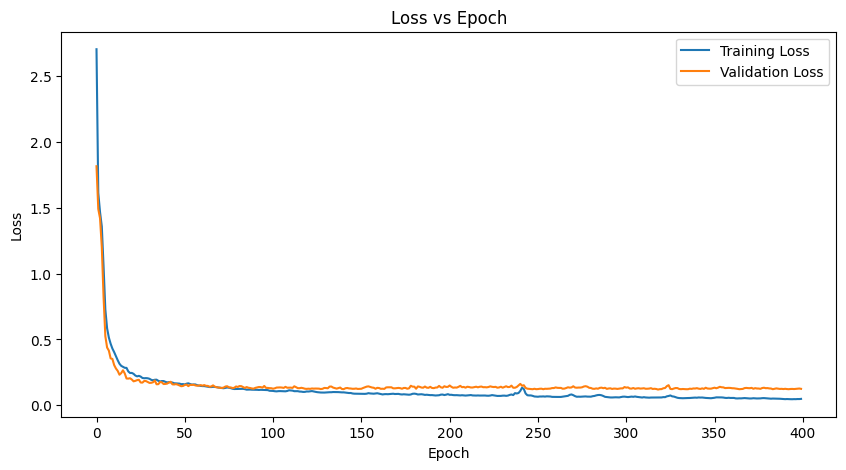

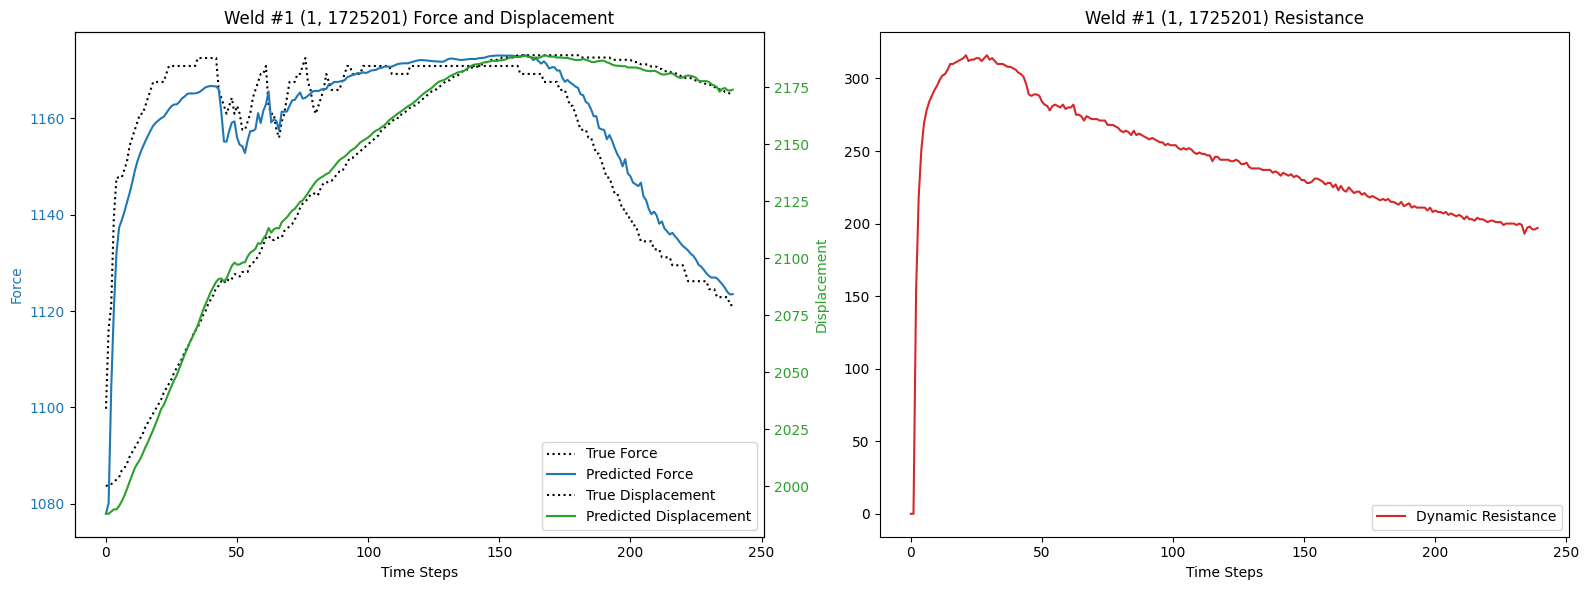

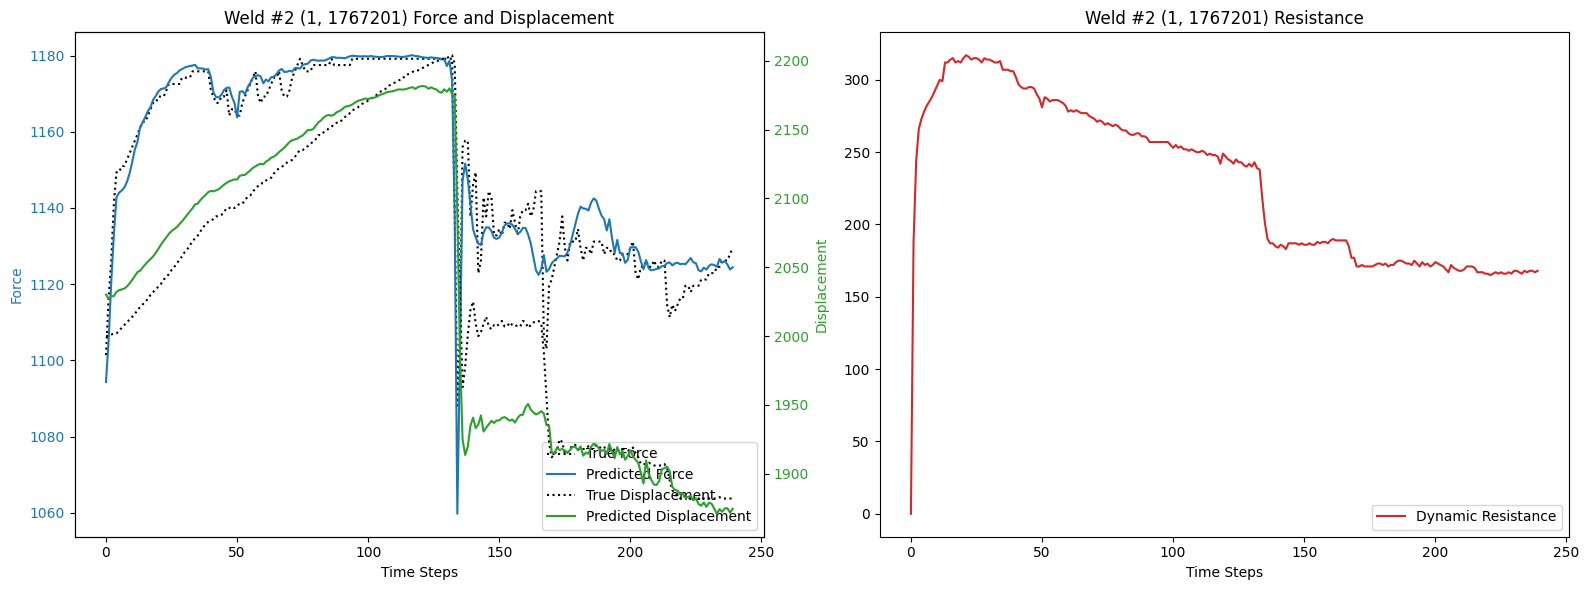

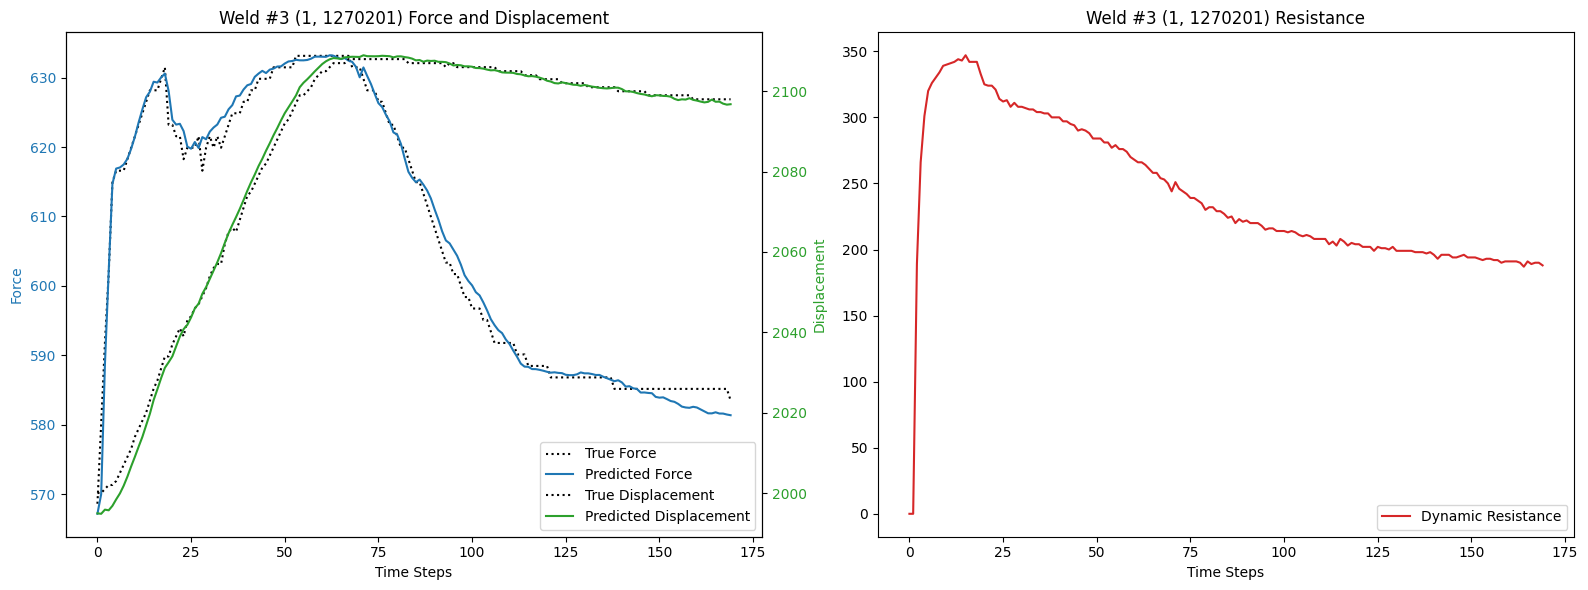

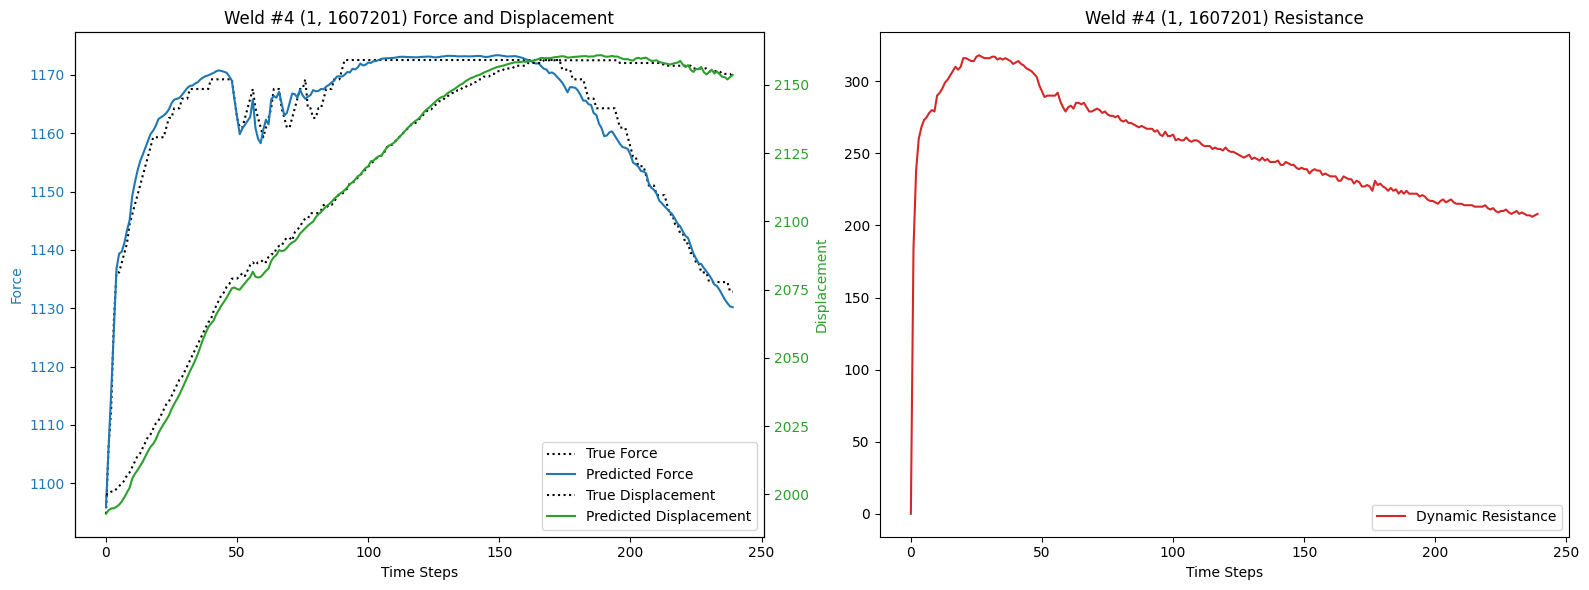

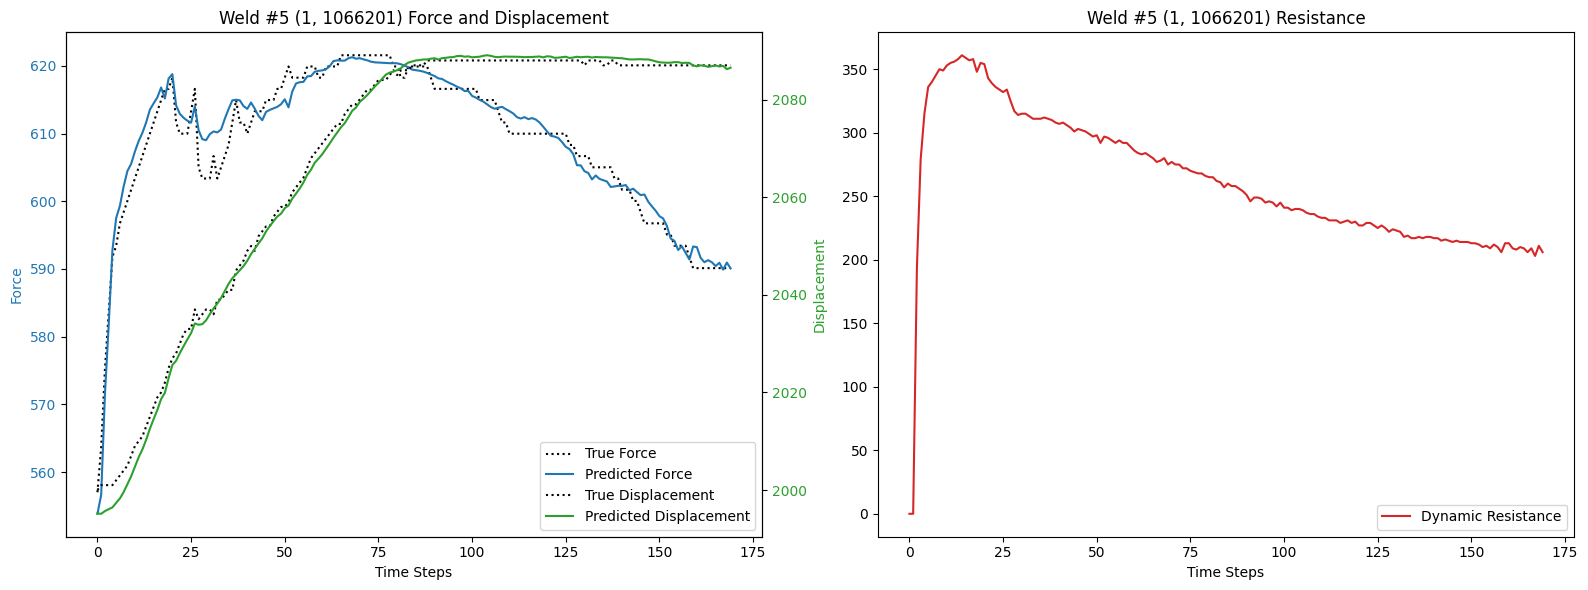

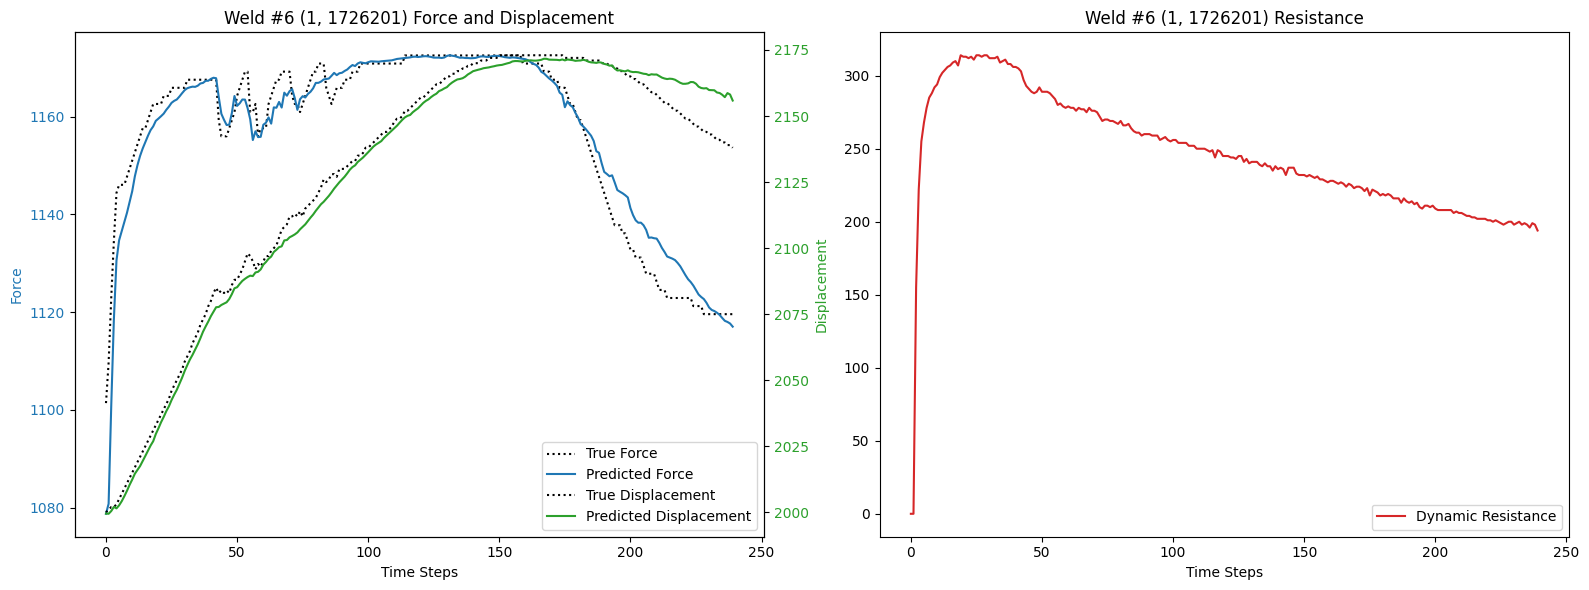

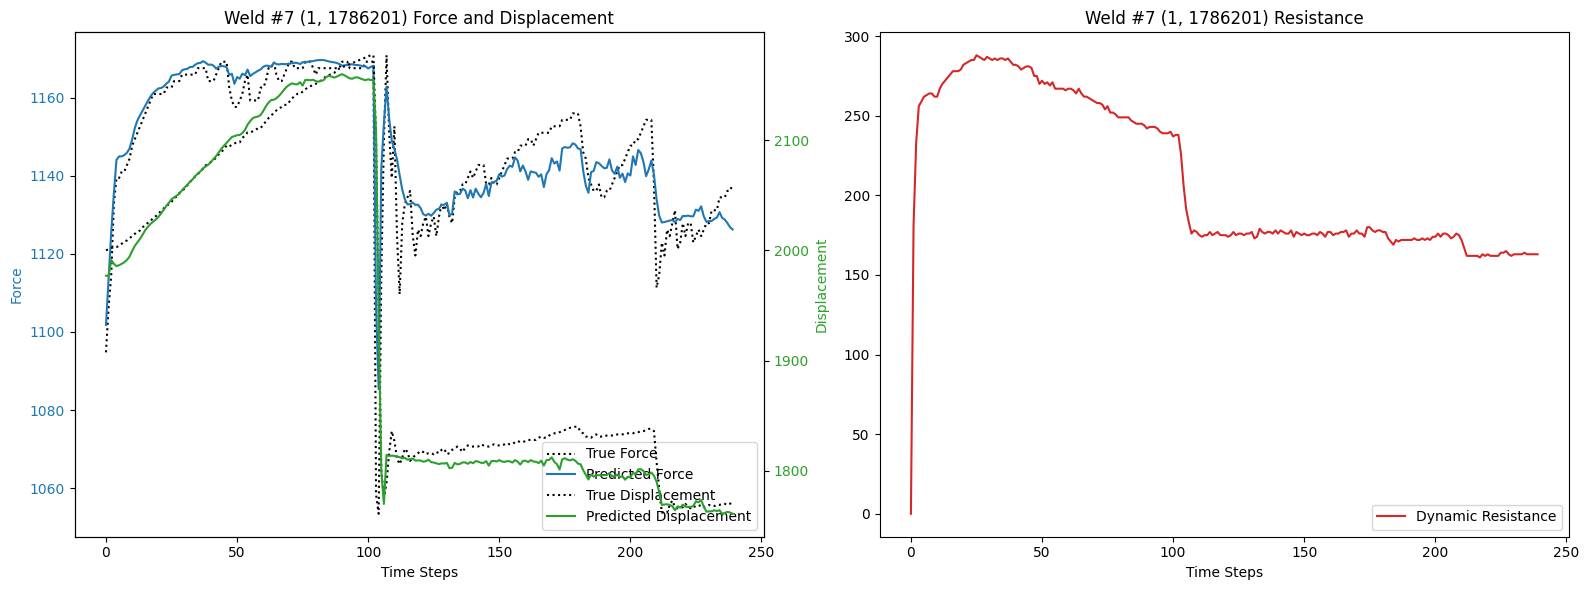

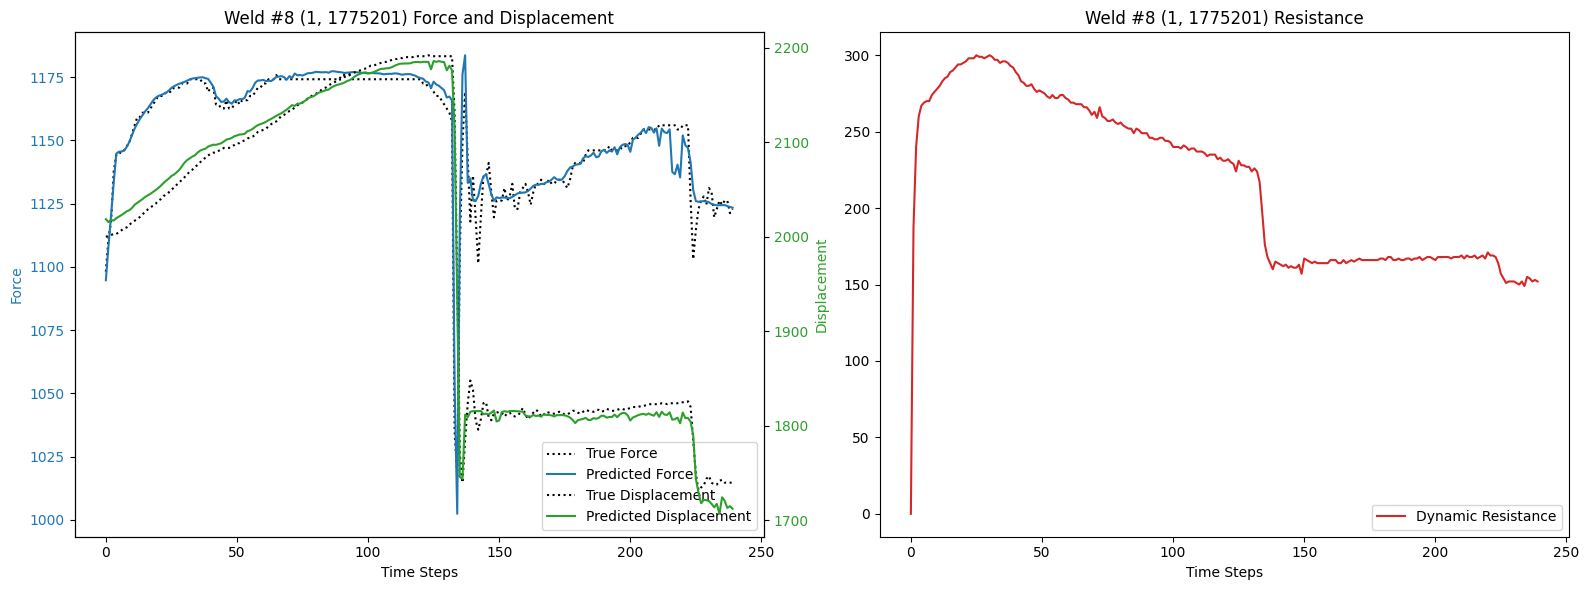

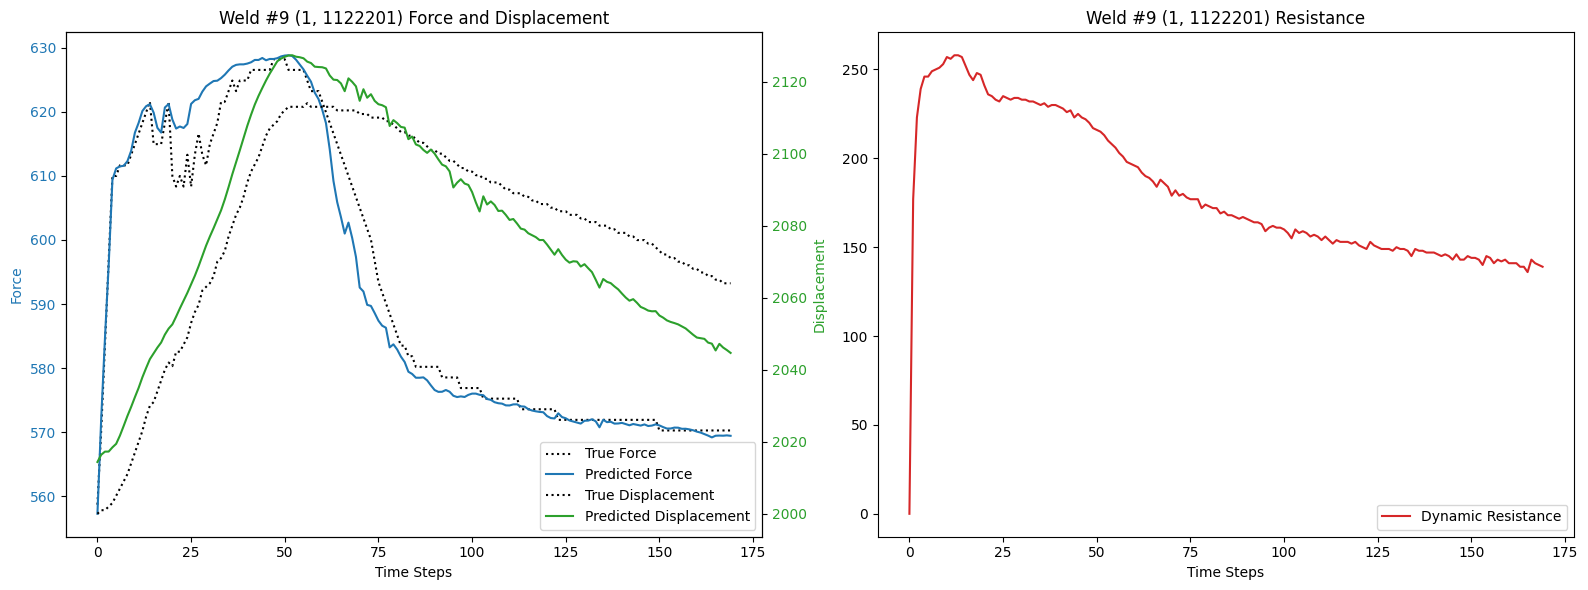

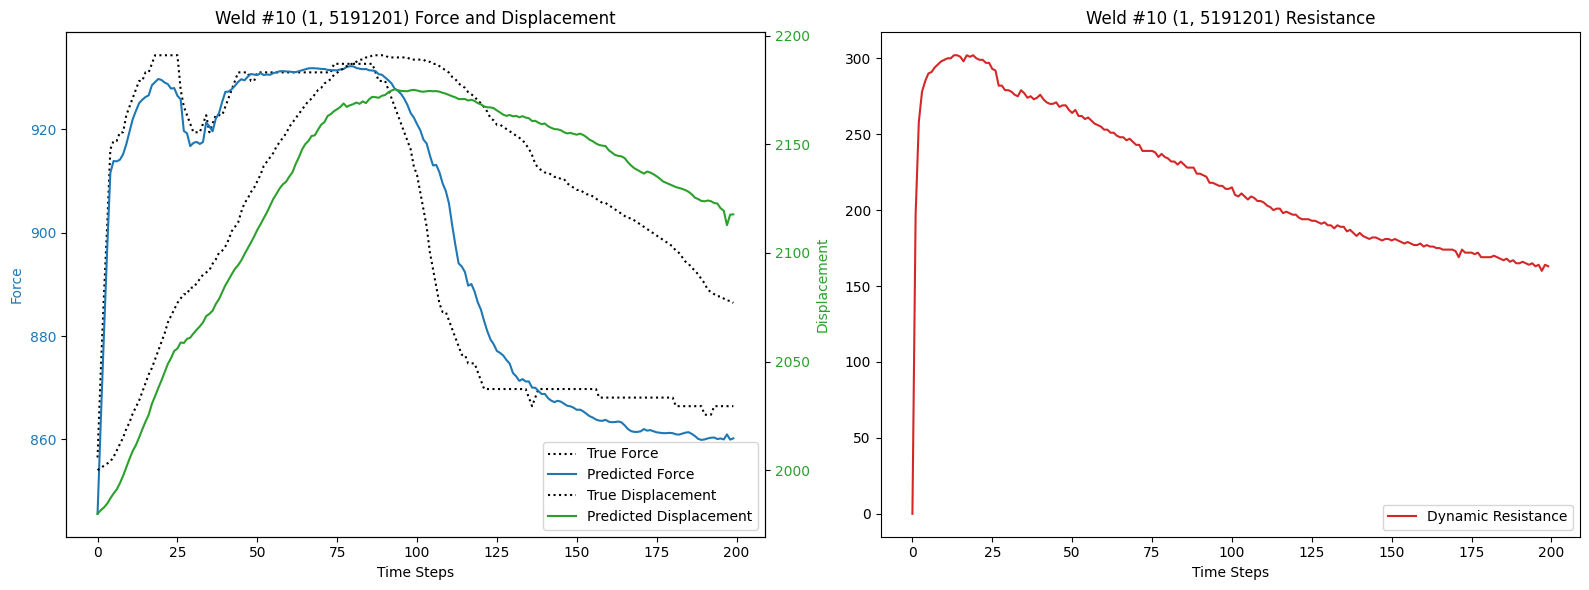

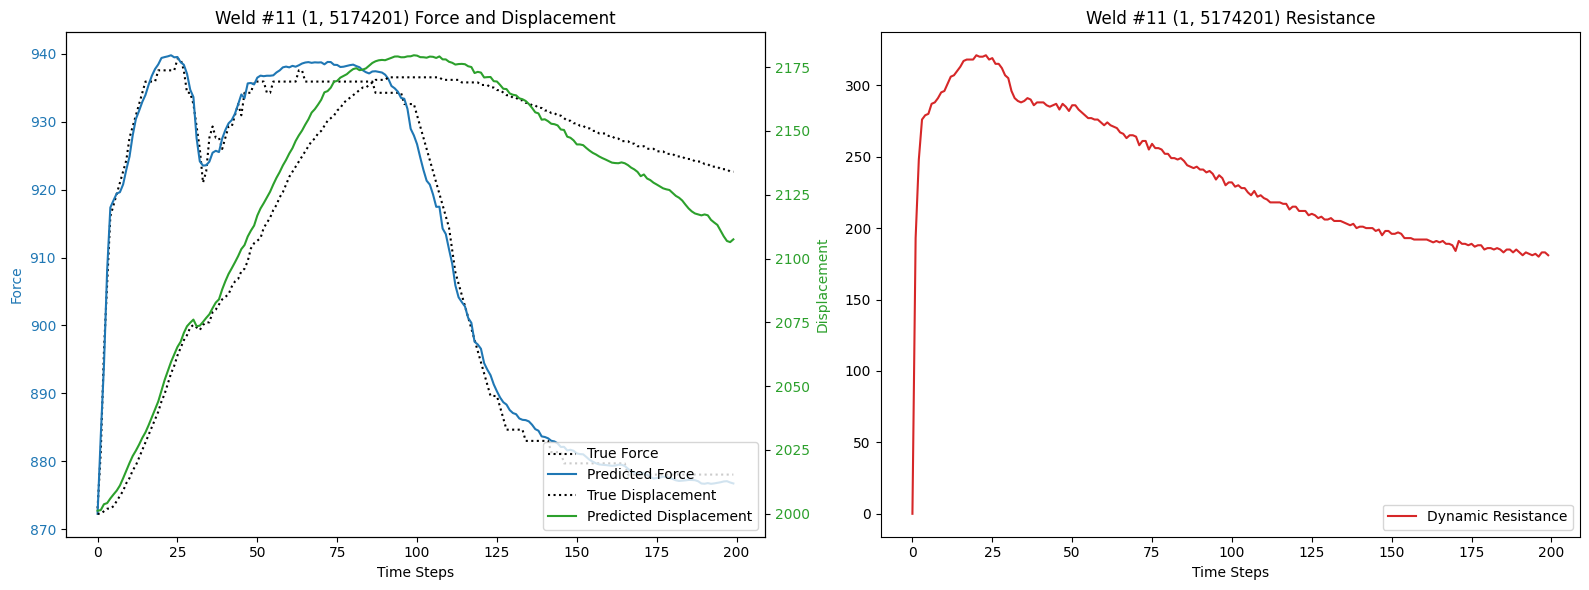

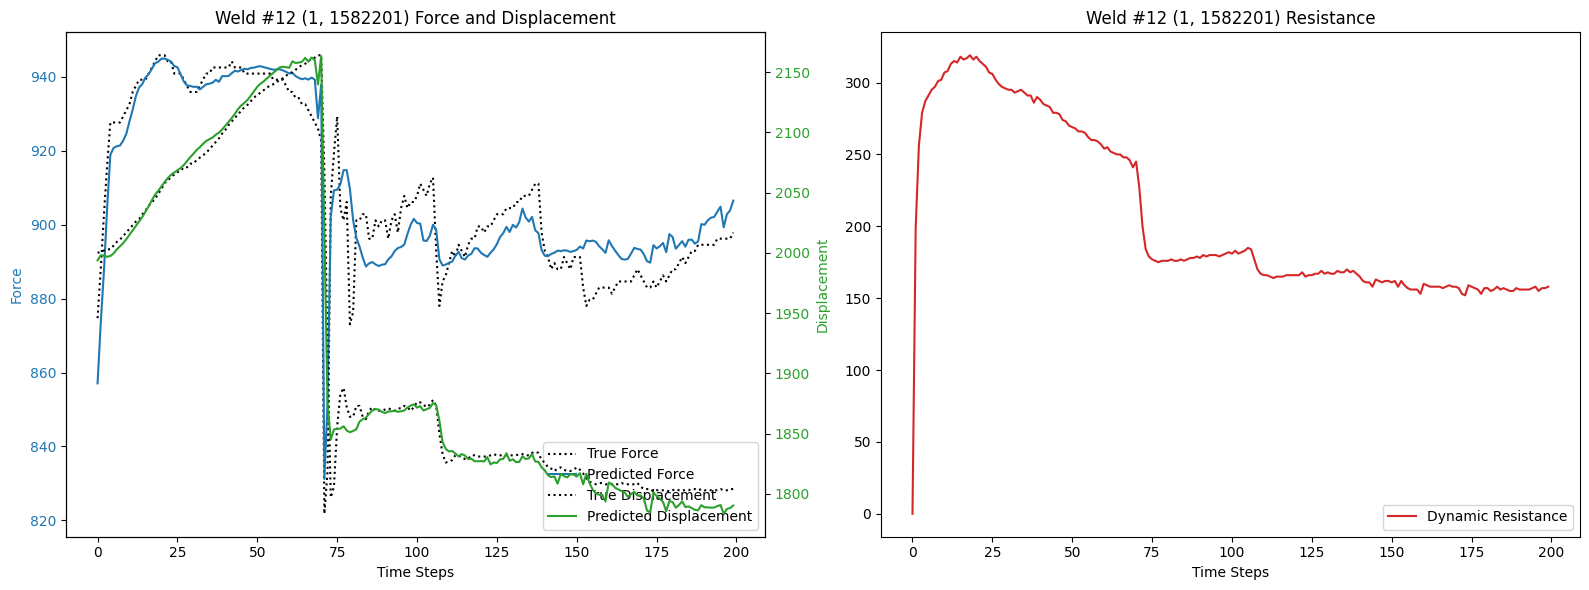

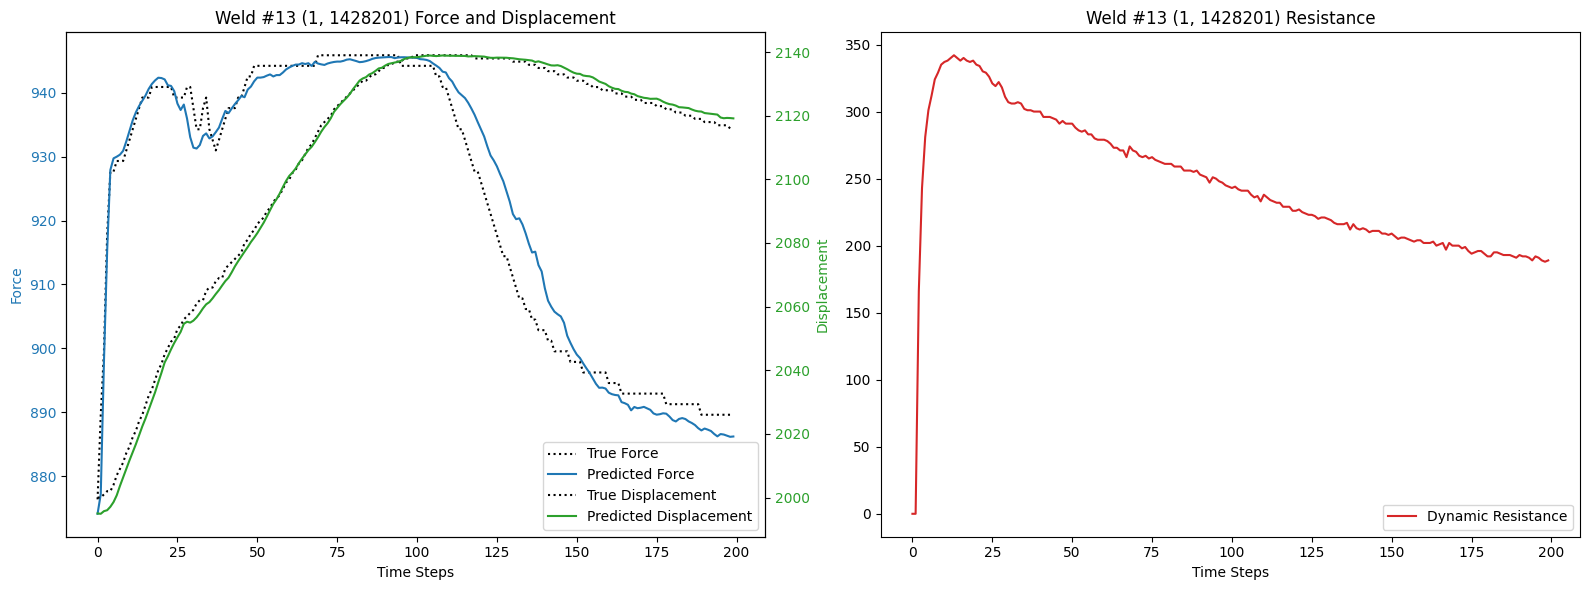

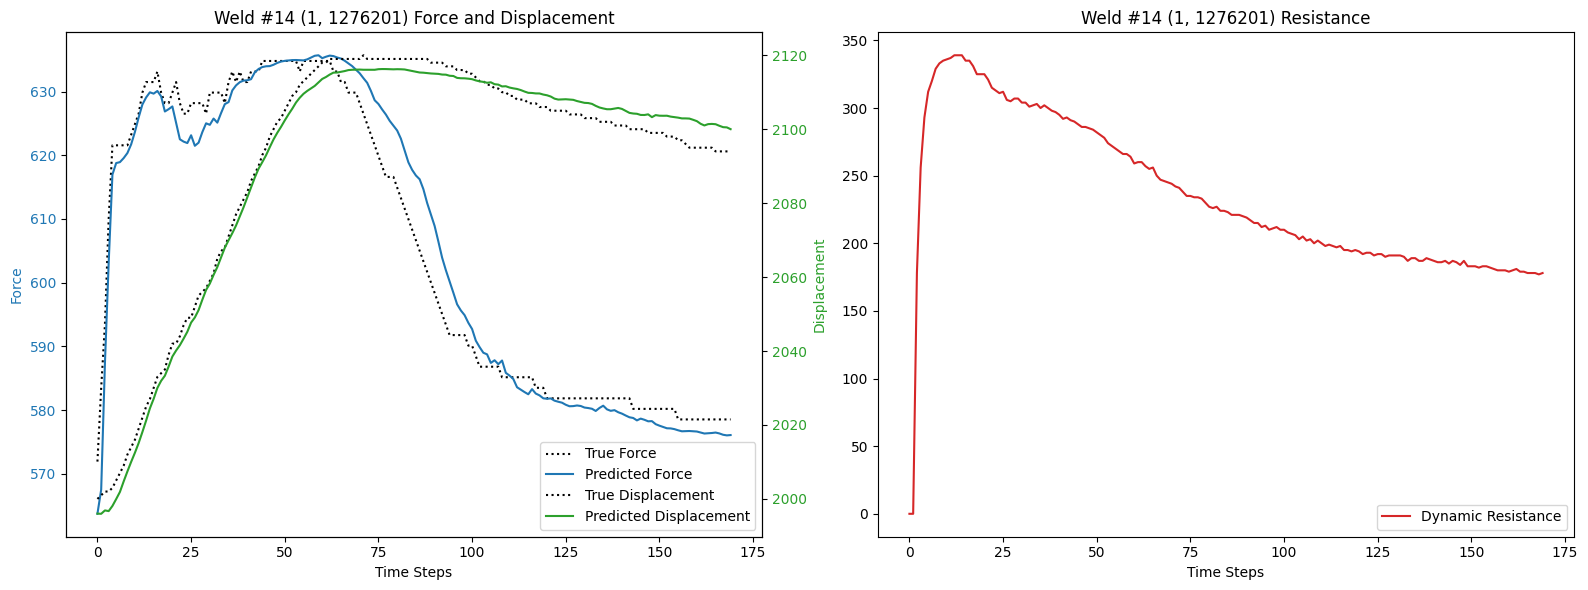

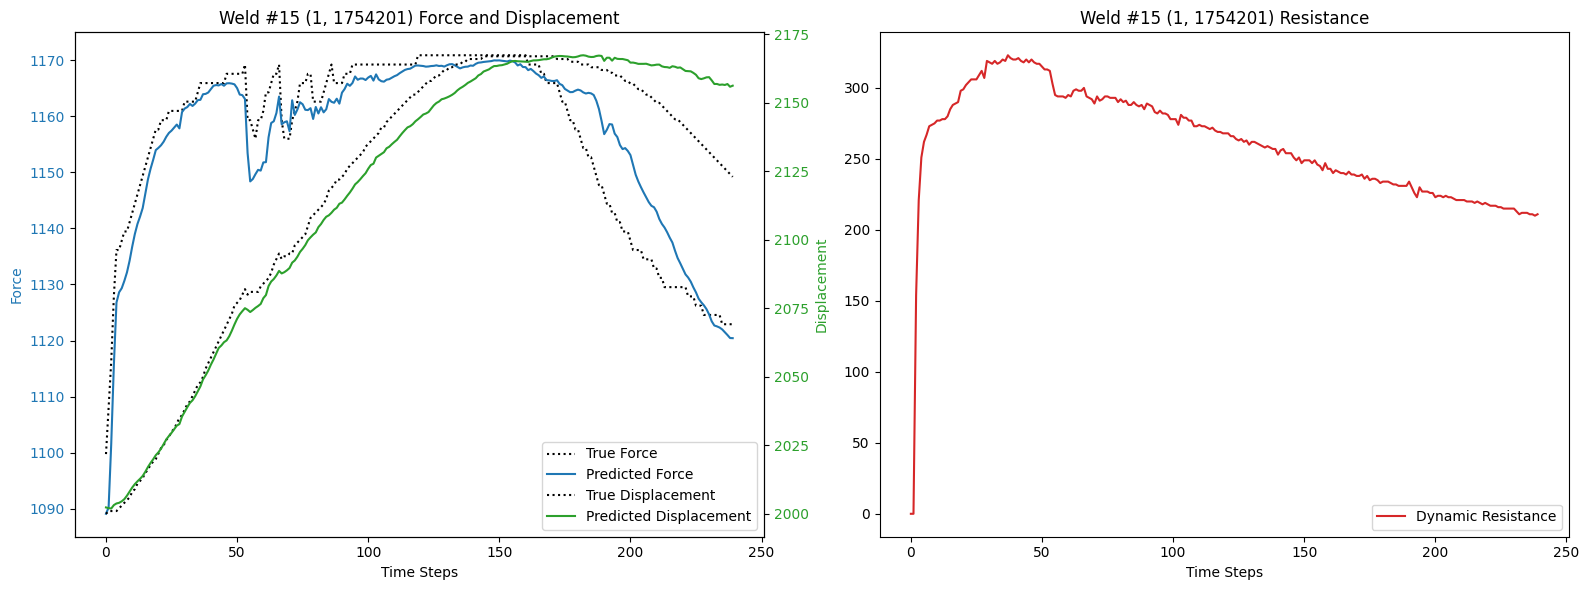

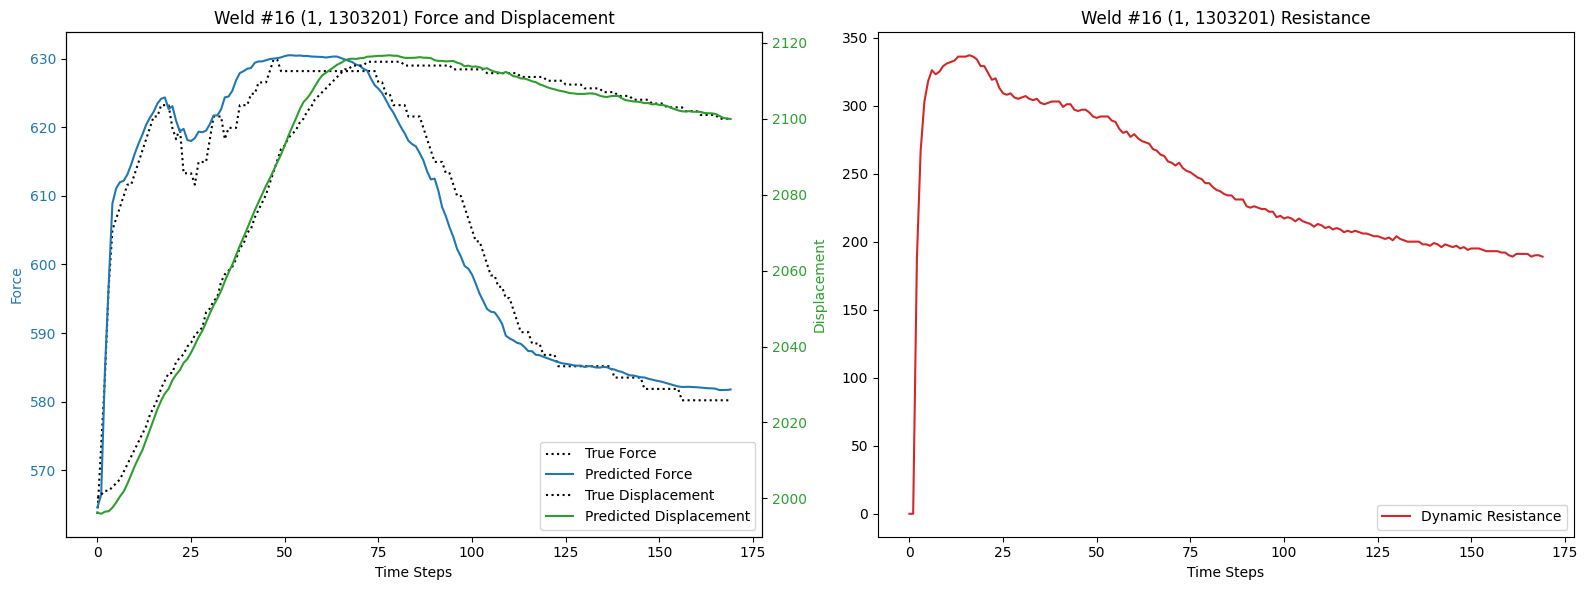

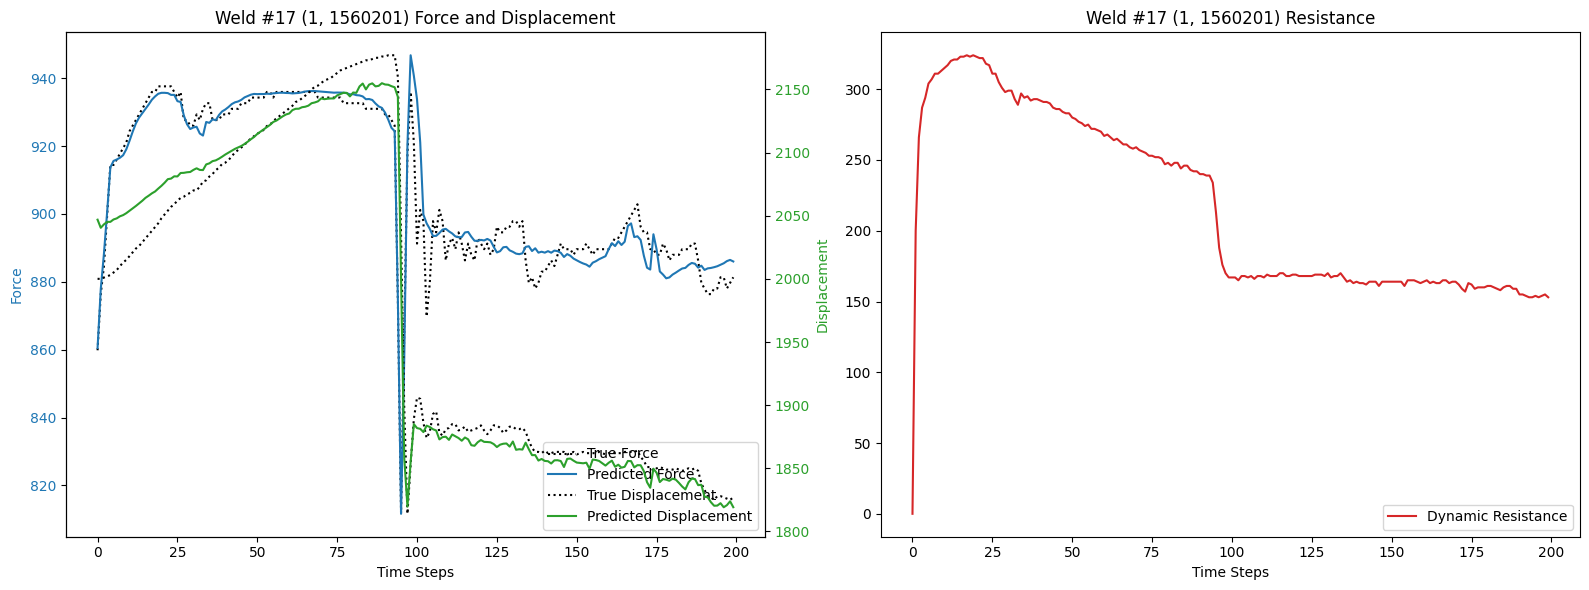

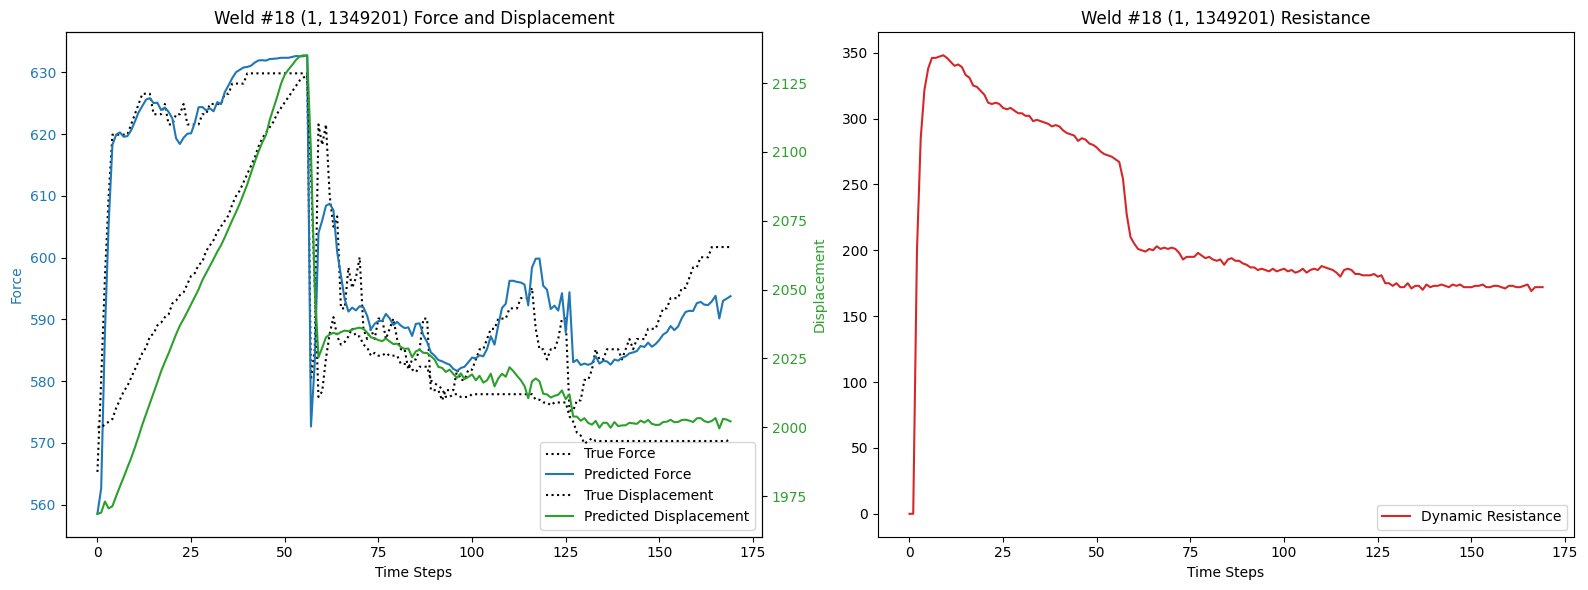

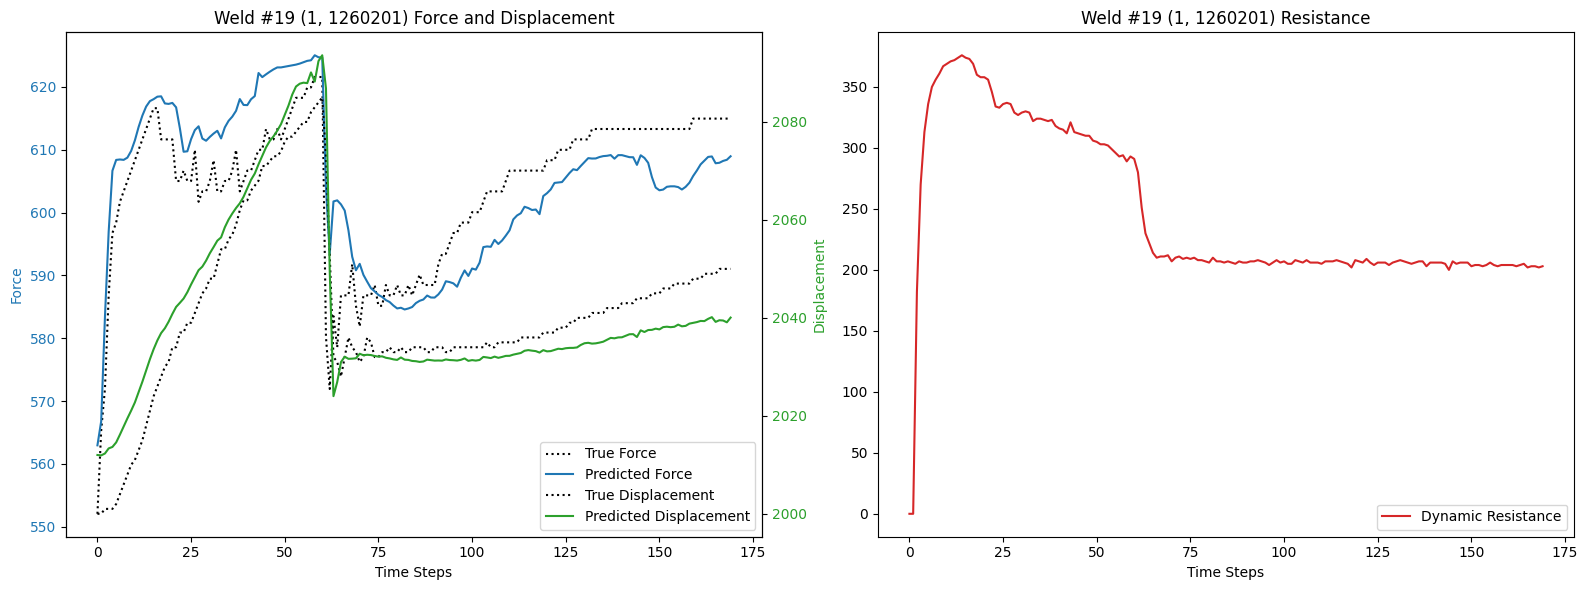

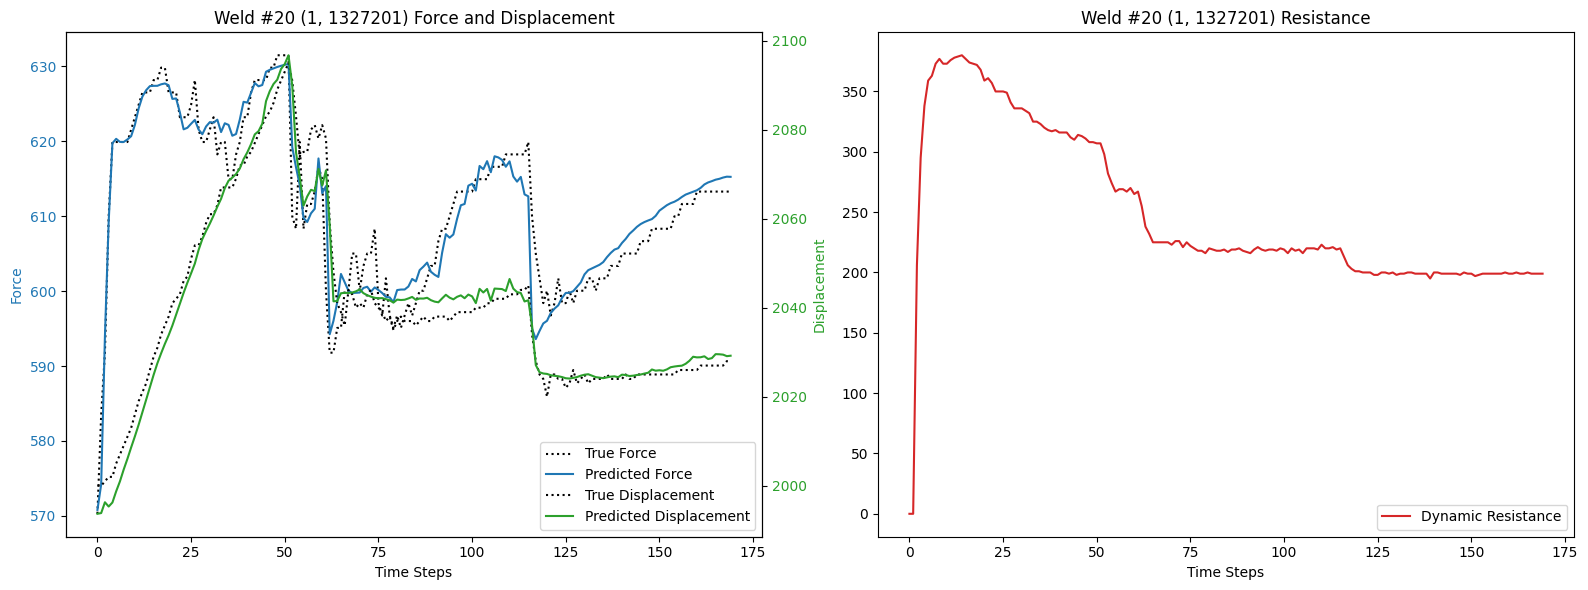

In [10]:
# Save test loss as the name of a .txt file
open(f"{model_save_path}_rmse - {average_rmse:.5f}", 'w')
open(f"{model_save_path}_r2 - {average_r2:.5f}", 'w')

# Load the loss data from the pickle file
with open(f"{model_save_path}_loss_data.pkl", 'rb') as file:
    loss_data = pickle.load(file)
train_loss_plot, val_los_plot = loss_data['train_losses'], loss_data['val_losses'] # Unpack the losses

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_plot, label='Training Loss')
plt.plot(val_los_plot, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{folder_path}/Loss vs Epoch.png') # Save the figure into the Figures folder
plt.show()

# Plot the predicted and input curves
for index, result in enumerate(results[0:20]):
    # Set up the subplot grid
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plotting the force on the first y-axis of the first plot
    color = 'tab:blue'
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Force', color=color)
    ax1.plot(result[1], label='True Force', color='black', linestyle=':')
    ax1.plot(result[2], label='Predicted Force', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating a second y-axis for the displacement in the first plot
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Displacement', color=color)
    ax2.plot(result[3], label='True Displacement', color='black', linestyle=':')
    ax2.plot(result[4], label='Predicted Displacement', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Combined legend for both axes in the first plot
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='lower right')

    # Setting the title for the first plot with the correct weld number and metadata
    ax1.set_title(f'Weld #{index+1} ({result[0]}) Force and Displacement')

    # Plotting resistance on the second plot
    ax3.plot(result[5], label='Dynamic Resistance', color='tab:red')
    ax3.set_title(f'Weld #{index+1} ({result[0]}) Resistance')
    ax3.set_xlabel('Time Steps')
    ax3.legend(loc='lower right')

    # Adjust layout to not overlap
    plt.tight_layout()

    # Save the figure into the Figures folder
    plt.savefig(f'{folder_path}/Weld_{index+1}_{result[0]}.png')

    plt.show()